# Text Classification



## Preprocess

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from google.colab import drive
from gensim.models import FastText
from nltk.tokenize import RegexpTokenizer
# KERAS
import tensorflow as tf
from tensorflow import keras
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
tag_df_processed = pd.read_csv('gdrive/MyDrive/save_file/data_tag_processed_20220124.csv')

In [4]:
tag_df_processed

,Document_No,value,tag
0,0,toko belanja online,5
1,1,beli power bank kualitas pdhl ngecas handphone...,3
2,2,kerennn bikin ribet,3
3,3,aplikasi belanja online,5
4,4,mudah belanja,5
...,...,...,...
759388,759388,aplikasimya bagusss,4
759389,759389,produk import asli hoki untung,2
759390,759390,bantu belanja online,5
759391,759391,belanja rumah cocok kaum mageran,5


In [5]:
tokenizer_data = RegexpTokenizer(r'\w+')
tag_df_processed['value_tokenize'] = tag_df_processed['value'].map(tokenizer_data.tokenize)

In [6]:
value = tag_df_processed["value_tokenize"]
tags = tag_df_processed["tag"]

## Word Embedding

In [8]:
sg_ft_model = FastText.load('gdrive/MyDrive/save_file/fasttext_sg_100.model')

In [9]:
words = len(sg_ft_model.wv.vocab)
print ('Vocabulary size: ', words)

Vocabulary size:  51399


In [10]:
ft_weights = sg_ft_model.wv.vectors
vocab_size, embedding_size = ft_weights.shape

## LSTM

In [11]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(value)
seq = tokenizer.texts_to_sequences(value)
X = pad_sequences(seq, padding = 'post')

print('X_shape: ', X.shape)
print('X_min: ', np.min(X))
print('X_max: ', np.max(X))

X_shape:  (759393, 70)
X_min:  0
X_max:  9999


In [12]:
y = pd.DataFrame(pd.get_dummies(tags))

In [13]:
from sklearn.model_selection import train_test_split

x_train_valid, x_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=42)

In [14]:
y_train

,0,1,2,3,4,5,6
144147,0,0,0,0,0,0,1
322455,0,0,1,0,0,0,0
377956,0,0,0,0,0,0,1
215089,0,0,1,0,0,0,0
347643,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
660514,0,0,0,0,0,0,1
427961,0,0,0,1,0,0,0
211825,0,0,1,0,0,0,0
250600,0,0,0,0,0,0,1


In [16]:
max_length = X.shape[1]

In [17]:
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim = vocab_size, output_dim=embedding_size, weights=[ft_weights], input_length = max_length, trainable=False, mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(7, activation = 'sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           5139900   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 5,182,595
Trainable params: 42,695
Non-trainable params: 5,139,900
_________________________________________________________________


In [18]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
15188/15188 [==============================] - 943s 62ms/step - loss: 0.7837 - accuracy: 0.7263 - val_loss: 0.6115 - val_accuracy: 0.7856
Epoch 2/5
15188/15188 [==============================] - 940s 62ms/step - loss: 0.5479 - accuracy: 0.8090 - val_loss: 0.5245 - val_accuracy: 0.8190
Epoch 3/5
15188/15188 [==============================] - 940s 62ms/step - loss: 0.4856 - accuracy: 0.8308 - val_loss: 0.4931 - val_accuracy: 0.8298
Epoch 4/5
15188/15188 [==============================] - 938s 62ms/step - loss: 0.4521 - accuracy: 0.8419 - val_loss: 0.4770 - val_accuracy: 0.8356
Epoch 5/5
15188/15188 [==============================] - 943s 62ms/step - loss: 0.4300 - accuracy: 0.8496 - val_loss: 0.4703 - val_accuracy: 0.8380


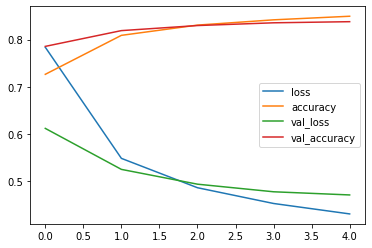

In [19]:
pd.DataFrame(history.history).plot()

In [20]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_test = np.argmax(y_test.to_numpy(), axis=1)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     21938
           1       0.87      0.88      0.88     22884
           2       0.81      0.87      0.84     21291
           3       0.81      0.77      0.79     17986
           4       0.78      0.70      0.74     12970
           5       0.89      0.84      0.87     24022
           6       0.81      0.87      0.84     30788

    accuracy                           0.84    151879
   macro avg       0.84      0.83      0.83    151879
weighted avg       0.84      0.84      0.84    151879



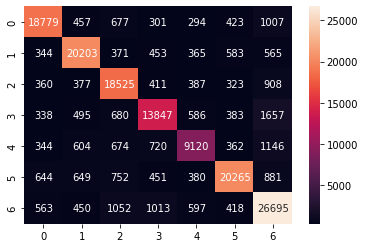

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f')

In [23]:
model.save('lstm.h5')